In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/My Drive/fruit dataset/Train_200'
target_categories = ['fresh_strawberry', 'fresh_pomegranate', 'stale_strawberry', 'stale_cucumber', 'stale_pomegranate', 'fresh_cucumber','fresh_peach',
                     'fresh_apple','fresh_banana','fresh_orange','fresh_tomato','stale_apple','stale_banana','stale_orange','stale_tomato','stale_peach']

In [ ]:
# Menghitung jumlah file dan kategori
file_count = 0
categories = set()

for dirpath, dirnames, filenames in os.walk(folder_path):
    file_count += len(filenames)
    categories.update(dirnames)  # Tambahkan kategori

print(f"Jumlah file: {file_count}")
print(f"Kategori: {categories}")

Jumlah file: 3200
Kategori: {'fresh_banana', 'fresh_pomegranate', 'stale_cucumber', 'fresh_apple', 'stale_peach', 'fresh_strawberry', 'fresh_orange', 'stale_orange', 'stale_banana', 'stale_apple', 'fresh_peach', 'fresh_tomato', 'stale_pomegranate', 'stale_strawberry', 'stale_tomato', 'fresh_cucumber'}


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,              # Normalisasi piksel gambar
    rotation_range=15,                # Rotasi gambar dalam rentang 10 derajat
    horizontal_flip=True,             # Membalik gambar secara horizontal
    vertical_flip=True,               # Membalik gambar secara vertikal
    validation_split=0.2              # Membagi data untuk validasi
)

In [ ]:
# Mendefinisikan fungsi pada augmentasi data untuk validasi
valid_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,              # Normalisasi piksel gambar
    validation_split=0.2               # Membagi data untuk validasi
)

In [ ]:
train_dataset = train_datagen.flow_from_directory(
    folder_path,
    target_size=(224, 224),             # Ubah ukuran sesuai kebutuhan
    batch_size=10,
    class_mode='categorical',         # Kategori untuk klasifikasi multi-kelas
    subset='training'                  # Menyediakan data pelatihan
)

Found 2560 images belonging to 16 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(
    folder_path,
    target_size=(224, 224),             # Ubah ukuran sesuai kebutuhan
    batch_size=10,
    class_mode='categorical',         # Kategori untuk klasifikasi multi-kelas
    subset='validation'                # Menyediakan data validasi
)

Found 640 images belonging to 16 classes.


In [ ]:
total = train_dataset.samples + valid_dataset.samples
total

3200

In [ ]:
train_dataset.class_indices

{'fresh_apple': 0,
 'fresh_banana': 1,
 'fresh_cucumber': 2,
 'fresh_orange': 3,
 'fresh_peach': 4,
 'fresh_pomegranate': 5,
 'fresh_strawberry': 6,
 'fresh_tomato': 7,
 'stale_apple': 8,
 'stale_banana': 9,
 'stale_cucumber': 10,
 'stale_orange': 11,
 'stale_peach': 12,
 'stale_pomegranate': 13,
 'stale_strawberry': 14,
 'stale_tomato': 15}

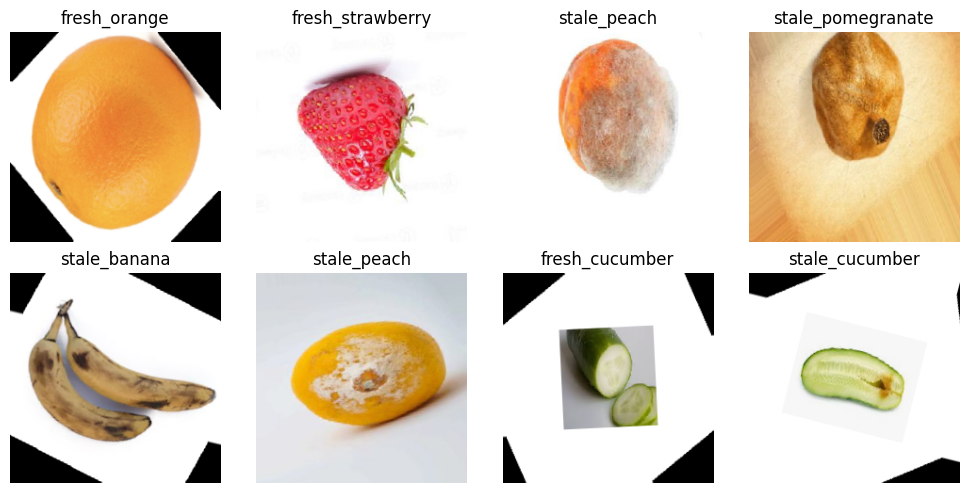

In [ ]:
# Misalkan train_dataset adalah daftar dari tuple (gambar, label)
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))

# Daftar nama kelas
class_names = ['fresh_apple',
 'fresh_banana',
 'fresh_cucumber',
 'fresh_orange',
 'fresh_peach',
 'fresh_pomegranate',
 'fresh_strawberry',
 'fresh_tomato',
 'stale_apple',
 'stale_banana',
 'stale_cucumber',
 'stale_orange',
 'stale_peach',
 'stale_pomegranate',
 'stale_strawberry',
 'stale_tomato']
for i in range(2):
    for j in range(4):
        rand1 = np.random.randint(len(train_dataset))  # Ambil indeks acak dari dataset
        rand2 = np.random.randint(10)  # Ambil indeks acak untuk gambar dalam batch
        ax[i, j].imshow(train_dataset[rand1][0][rand2])  # Tampilkan gambar
        ax[i, j].axis('off')  # Matikan sumbu
        label = train_dataset[rand1][1][rand2]  # Ambil label untuk gambar
        class_label = np.argmax(label)  # Dapatkan indeks dari nilai maksimum dalam array label

        # Set judul berdasarkan kelas
        ax[i, j].set_title(class_names[class_label])

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf

In [ ]:
pretrained_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False)
pretrained_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
pretrained_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
"""pretrained_model.trainable = True
for layer in pretrained_model.layers[:-50]:  # Membekukan sebagian besar layer awal
    layer.trainable = False"""

'pretrained_model.trainable = True\nfor layer in pretrained_model.layers[:-50]:  # Membekukan sebagian besar layer awal\n    layer.trainable = False'

In [ ]:
model = Sequential([
    pretrained_model,  # Pretrained MobileNetV2
    Flatten(),  # Flatten feature maps

    Dense(128, kernel_regularizer=l2(0.01)),  # Fully connected layer
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),  # Dropout to prevent overfitting

    Dense(64, kernel_regularizer=l2(0.01)),  # Fully connected layer
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),

    Dense(len(train_dataset.class_indices), activation='softmax')  # Output layer
])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,028,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │           1,040 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,296,336 (39.28 MB)

 Trainable params: 8,037,968 (30.66 MB)

 Non-trainable params: 2,258,368 (8.61 MB)

In [ ]:
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

In [ ]:
model_history=model.fit(train_dataset,
                         validation_data=valid_dataset,
                         epochs = 15,
                         verbose = 1)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


256/256 ━━━━━━━━━━━━━━━━━━━━ 904s 3s/step - accuracy: 0.2960 - loss: 5.4916 - val_accuracy: 0.7359 - val_loss: 4.0143
Epoch 2/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 70s 177ms/step - accuracy: 0.6150 - loss: 4.2054 - val_accuracy: 0.7922 - val_loss: 3.4906
Epoch 3/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 47s 177ms/step - accuracy: 0.7024 - loss: 3.6252 - val_accuracy: 0.8266 - val_loss: 3.0969
Epoch 4/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 81s 176ms/step - accuracy: 0.7557 - loss: 3.2188 - val_accuracy: 0.8406 - val_loss: 2.7344
Epoch 5/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 46s 177ms/step - accuracy: 0.7875 - loss: 2.8628 - val_accuracy: 0.8625 - val_loss: 2.4654
Epoch 6/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 82s 178ms/step - accuracy: 0.8311 - loss: 2.5554 - val_accuracy: 0.8578 - val_loss: 2.2181
Epoch 7/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 82s 175ms/step - accuracy: 0.8386 - loss: 2.3400 - val_accuracy: 0.8594 - val_loss: 2.0870
Epoch 8/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 83s 181ms/step - accuracy: 0.8499 - loss: 2.1628 - val_a

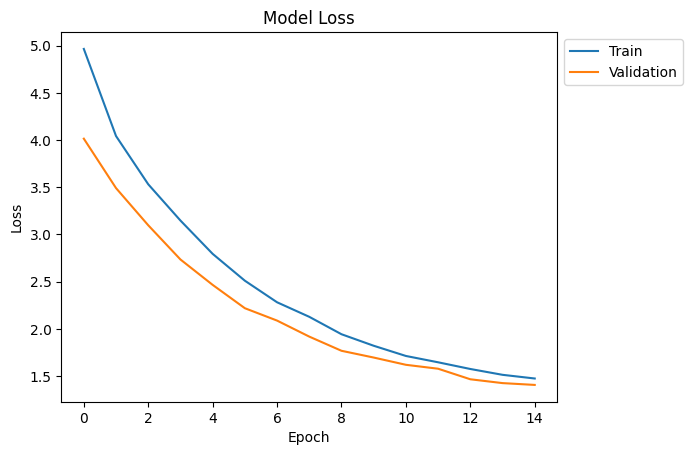

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

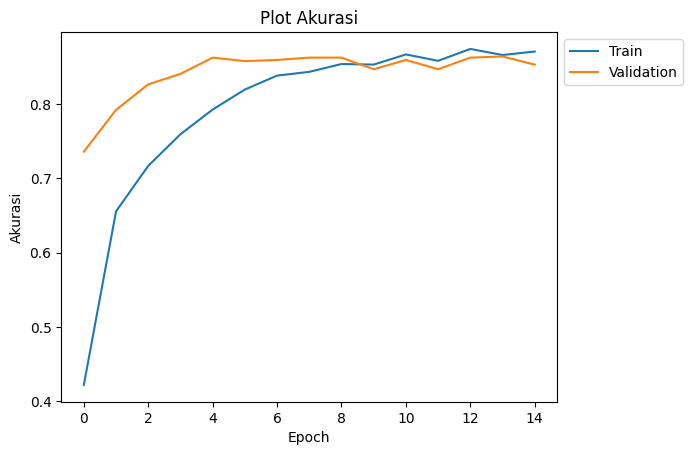

In [ ]:
#Plot model accuracy selama pelatihan
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Plot Akurasi')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
loss, acc = model.evaluate(train_dataset, verbose=1) #Mengevaluasi hasil model
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

256/256 ━━━━━━━━━━━━━━━━━━━━ 42s 165ms/step - accuracy: 0.9744 - loss: 1.0747
Restored model, accuracy: 97.58%


In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,              # Normalisasi piksel gambar
    rotation_range=10,                # Rotasi gambar dalam rentang 10 derajat
    horizontal_flip=True,             # Membalik gambar secara horizontal
    vertical_flip=True,               # Membalik gambar secara vertikal
    validation_split=0.2              # Membagi data untuk validasi
)

test_data = test_datagen.flow_from_directory(
    folder_path,
    target_size=(224, 224),             # Ubah ukuran sesuai kebutuhan
    batch_size=32,
    class_mode='categorical',         # Kategori untuk klasifikasi multi-kelas
    subset='validation'                  # Menyediakan data pelatihan
)

#Mengevaluasi model dengan data baru
model.evaluate(test_data)

Found 640 images belonging to 16 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 448ms/step - accuracy: 0.8073 - loss: 1.5137


[1.4316179752349854, 0.8421875238418579]

64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step


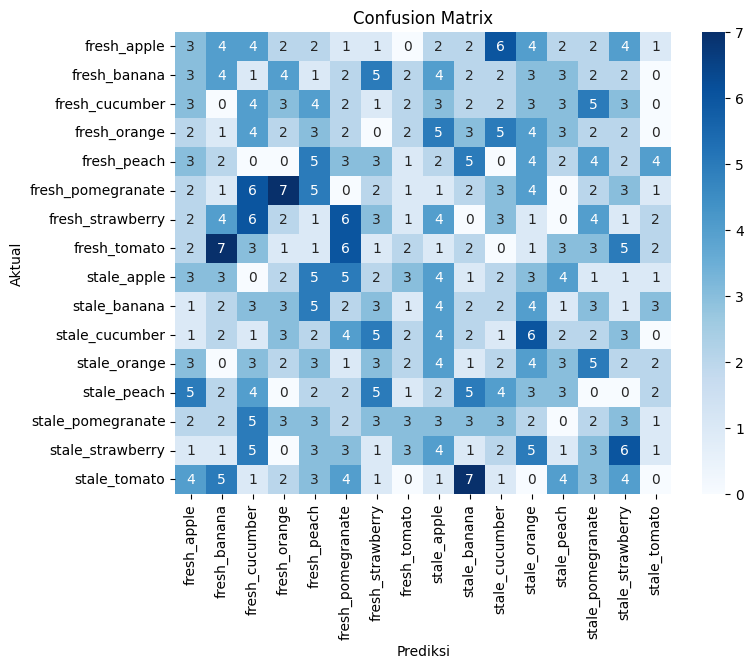

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Generate confusion matrix

from sklearn.metrics import classification_report
# Make predictions on the validation dataset
predictions = model.predict(valid_dataset)

# Get true labels from the dataset
true_labels = valid_dataset.classes
class_indices = valid_dataset.class_indices
class_labels = {v: k for k, v in class_indices.items()}

# Convert predicted probabilities to predicted labels
predicted_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

In [ ]:
# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=list(class_labels.values()))

# Display the classification report
print("Classification Report:\n", report)

Classification Report:
                    precision    recall  f1-score   support

      fresh_apple       0.07      0.07      0.07        40
     fresh_banana       0.10      0.10      0.10        40
   fresh_cucumber       0.08      0.10      0.09        40
     fresh_orange       0.06      0.05      0.05        40
      fresh_peach       0.10      0.12      0.11        40
fresh_pomegranate       0.00      0.00      0.00        40
 fresh_strawberry       0.08      0.07      0.08        40
     fresh_tomato       0.08      0.05      0.06        40
      stale_apple       0.08      0.10      0.09        40
     stale_banana       0.05      0.05      0.05        40
   stale_cucumber       0.03      0.03      0.03        40
     stale_orange       0.08      0.10      0.09        40
      stale_peach       0.09      0.07      0.08        40
stale_pomegranate       0.05      0.05      0.05        40
 stale_strawberry       0.14      0.15      0.15        40
     stale_tomato       0.00   

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediksi: stale_strawberry (Probabilitas: 0.70)


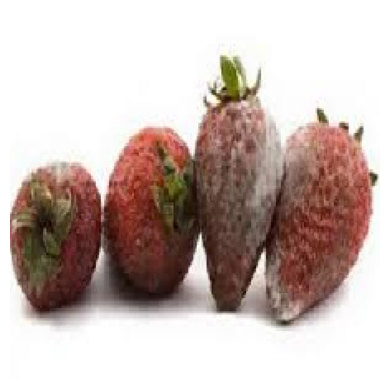

In [ ]:
#Memprediksi model menggunakan data baru
from matplotlib.pyplot import imshow
img_path = '/content/drive/My Drive/fruit dataset/Test/Strawberry/test 1.jpg'
dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img(img_path, target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)

answer = model.predict(img)

# Menentukan kelas dengan threshold
predicted_class = np.argmax(answer[0])  # Mendapatkan indeks kelas dengan probabilitas tertinggi
predicted_label = idc[predicted_class]  # Mendapatkan label kelas

print(f"Prediksi: {predicted_label} (Probabilitas: {answer[0][predicted_class]:.2f})")

In [ ]:
# prompt: compile to .h5

import tensorflow as tf

# Assuming your model is named 'model'
model.save('/content/drive/My Drive/fruit dataset/model3.h5')

In [ ]:
# prompt: compile model h5 to tflite

import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('/content/drive/My Drive/fruit dataset/model3.h5')

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('/content/drive/My Drive/fruit dataset/model3.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmps5yfl96x'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 16), dtype=tf.float32, name=None)
Captures:
  132332632734560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132332429338832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132332429340944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132332429334256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132332429336544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132332429342528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132332429340592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132332429341296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132332429343408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132332429379008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132332429339